In [1]:
import gains as genetic
from gains import adaptive as ald
import salty
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from rdkit.Chem import Draw
from rdkit import Chem
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('../data/adaptive_learn_results.csv')

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.six import iteritems
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.pyplot import figure
from rdkit.Chem.Draw.canvasbase import CanvasBase
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
from scipy.constants import golden as phi

class Canvas(CanvasBase):

  def __init__(self, size, name='', imageType='png'):
    self._name = name
    self.size = size
    dpi = max(size[0], size[1])
    figsize = (int(float(size[0]) / dpi), int(float(size[1]) / dpi))
    self._figure = figure(figsize=figsize)
    self._axes = self._figure.add_axes([0, 0, 2.5, 2.5])
    self._axes.set_xticklabels('')
    self._axes.set_yticklabels('')
    self._axes.get_xaxis().set_visible(False)
    self._axes.get_yaxis().set_visible(False)
    self._dpi = dpi

  def rescalePt(self, p1):
    return [float(p1[0]) / self._dpi, float(self.size[1] - p1[1]) / self._dpi]

  def addCanvasLine(self, p1, p2, color=(0, 0, 0), color2=None, **kwargs):
    canvas = self._axes
    p1 = self.rescalePt(p1)
    p2 = self.rescalePt(p2)
    if color2 and color2 != color:
      mp = (p1[0] + p2[0]) / 2., (p1[1] + p2[1]) / 2.
      canvas.add_line(Line2D((p1[0], mp[0]), (p1[1], mp[1]), color=color, **kwargs))
      canvas.add_line(Line2D((mp[0], p2[0]), (mp[1], p2[1]), color=color2, **kwargs))
    else:
      canvas.add_line(Line2D((p1[0], p2[0]), (p1[1], p2[1]), color=color, **kwargs))
    
  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))
  def addCanvasText(self, text, pos, font, color=(0, 0, 0), **kwargs):
    import re
    pos = self.rescalePt(pos)
    canvas = self._axes
    text = re.sub(r'<.*?>', '', text)
    orientation = kwargs.get('orientation', 'E')
    halign = 'center'
    valign = 'center'
    if orientation == 'E':
      halign = 'left'
    elif orientation == 'W':
      halign = 'right'
    elif orientation == 'S':
      valign = 'top'
    elif orientation == 'N':
      valign = 'bottom'

    annot = canvas.annotate(text, (pos[0], pos[1]), color=color, verticalalignment=valign,
                            horizontalalignment=halign, weight=font.weight, size=font.size * 2.0,
                            family=font.face)

    try:
      bb = annot.get_window_extent(renderer=self._figure.canvas.get_renderer())
      w, h = bb.width, bb.height
      tw, th = canvas.transData.inverted().transform((w, h))
    except AttributeError:
      tw, th = 0.1, 0.1  # <- kludge
    return (tw, th, 0)

  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))

def draw(smiles, size=(300, 300), kekulize=True, wedgeBonds=True, imageType=None, fitImage=False, options=None, **kwargs):
    """
    draw smiles to notebook with RDKit
    
    and without those dumb matplotlib ticks
    
    ¯\_(ツ)_/¯
    
    """
    canvas = Canvas(size)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.Mol(mol.ToBinary())
    Chem.Kekulize(mol)
    AllChem.Compute2DCoords(mol)
    drawer = MolDrawing(canvas=canvas)
    omol = mol
    drawer.AddMol(mol)
    omol._atomPs = drawer.atomPs[mol]
    for k, v in iteritems(omol._atomPs):
        omol._atomPs[k] = canvas.rescalePt(v)
    canvas._figure.set_size_inches(float(size[0]) / 100, float(size[1]) / 100)
    canvas._figure
    return canvas._figure

Using TensorFlow backend.


In [5]:
cpt_dens_errors = np.zeros((2,4))
for i in range(1,5):
    dff = df.loc[df['Series'] == 1]
    dff = dff.loc[dff['Round'] == i]
    cpt_dens_errors[0,i-1] = np.average(dff['% error, cpt'])
    cpt_dens_errors[1,i-1] = np.average(dff['% error, density'])

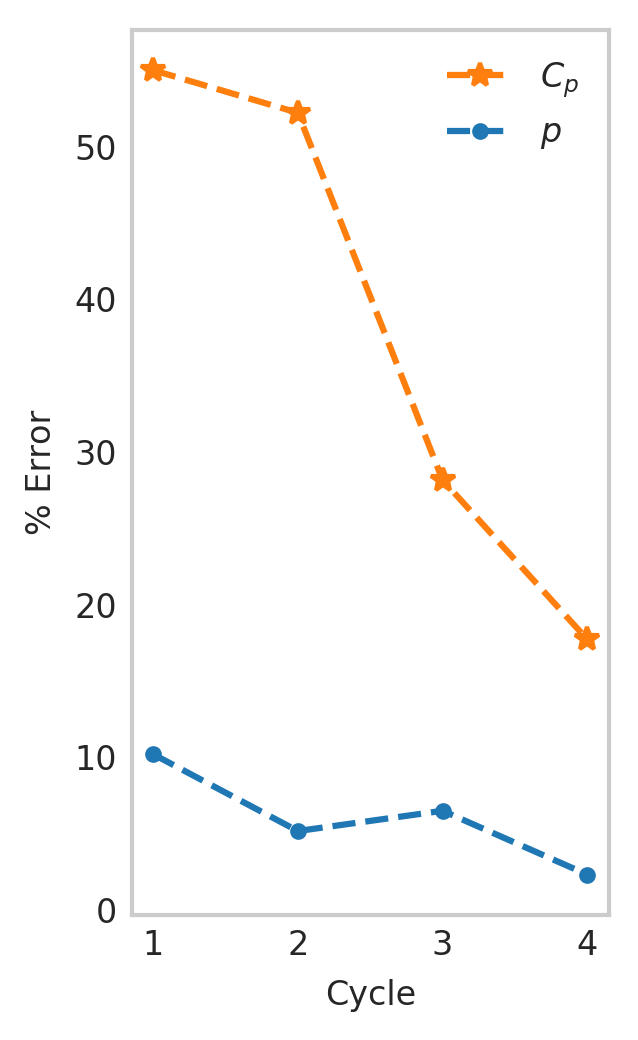

In [83]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3.5/phi,3.5), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(np.arange(1,5), cpt_dens_errors[0], 'k--', marker='*', label='$C_p$', c='tab:orange')
    ax.plot(np.arange(1,5), cpt_dens_errors[1], 'k--', marker='.', label='$p$', c='tab:blue')
    plt.grid()
    plt.legend()
    plt.xlabel('Cycle')
    plt.ylabel('% Error')
    plt.tick_params(direction='in')
    plt.tight_layout()

In [3]:
#set axis limits for all subplots
dff = df.loc[(df['Series'] == 1)]
minval = np.min([dff['predicted cpt'],dff['calculated cpt'],
                     dff['predicted density'],dff['calculated density']])
maxval = np.max([dff['predicted cpt'],dff['calculated cpt'],
                     dff['predicted density'],dff['calculated density']])
buffer = (maxval - minval) / 100 * 2
minval = minval - buffer
maxval = maxval + buffer

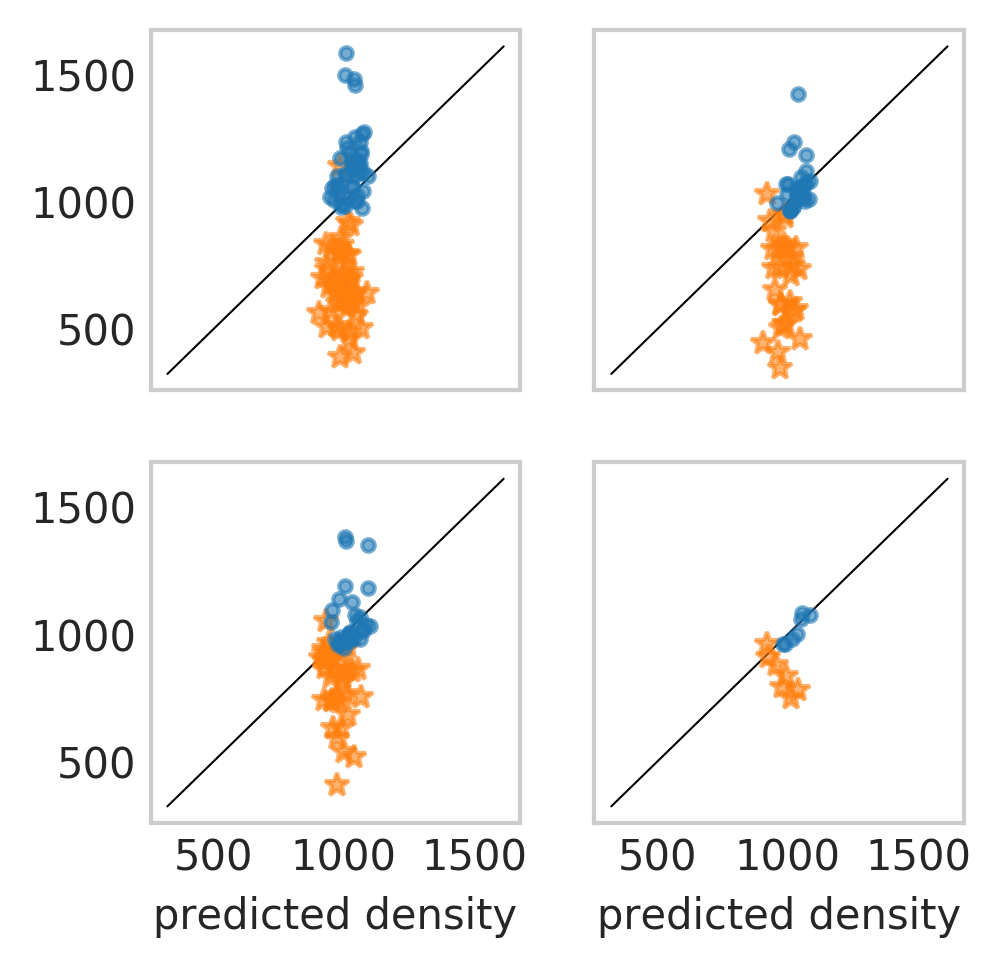

In [4]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3.5,3.5), dpi=300)    
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)   
    ax3=fig.add_subplot(223)
    ax4=fig.add_subplot(224)

    ax1.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 1)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax1, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharex=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax1, color='tab:blue', grid=False, alpha=0.6,
             legend=False)

    ax2.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 2)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax2, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharey=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax2, color='tab:blue', grid=False, alpha=0.6,
             legend=False)
    
    ax3.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 3)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax3, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharey=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax3, color='tab:blue', grid=False, alpha=0.6,
             legend=False)
    
    ax4.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 4)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax4, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharey=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax4, color='tab:blue', grid=False, alpha=0.6,
             legend=False)

In [5]:
IPythonConsole.ipython_useSVG=True
dff = df.loc[(df['Series'] == 1) & (df['Round'] == 4)]
dff.reset_index(inplace=True)
ms = [Chem.MolFromSmiles(y) for y in dff['Salt Smiles']]
labels = ['{}  {}'.format(str(x), str(y)) for x,y in dff[['% error, cpt', '% error, density']].values]
fig = Draw.MolsToGridImage(ms,legends=labels,molsPerRow=2)
fig

ModuleNotFoundError: No module named 'IPythonConsole'

     % error, cpt  % error, density          Anion
383         35.08              0.84    L-prolinate
384         23.23              3.51    L-prolinate
385         19.04              0.68     L-lysinate
386          1.10              2.02  octyl sulfate
387          4.34              2.96  octyl sulfate
388         32.54              2.71  octyl sulfate
389          8.69              3.43  octyl sulfate


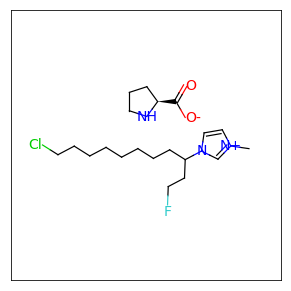

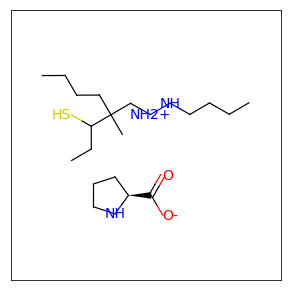

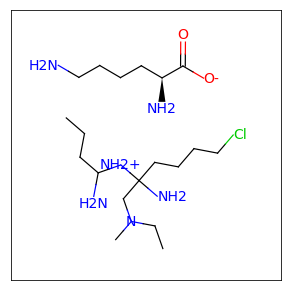

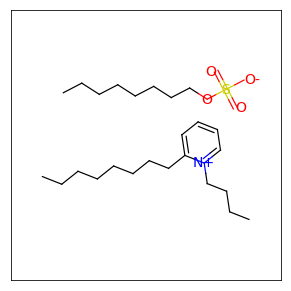

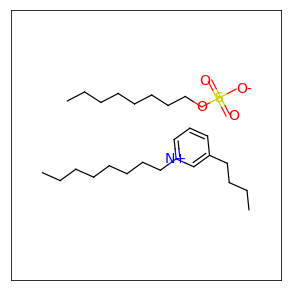

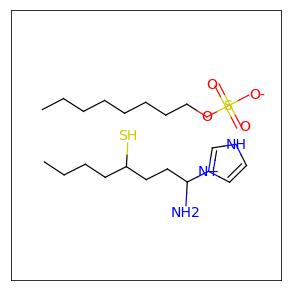

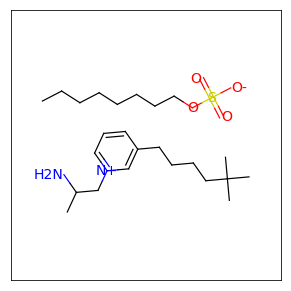

In [7]:
dff = df.loc[(df['Series'] == 1) & (df['Round'] == 4)]
print(dff[['% error, cpt', '% error, density', 'Anion']])
for i in dff['Salt Smiles']:
    draw(i, size=(150,150))

In [301]:
for i in dff['Salt Smiles']:
    img = draw(i, size=(150,150))
    img.savefig(fname="assets/{}.svg".format(i), 
                bbox_inches='tight', format='svg', transparent=True) 
    img.clf()

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>